In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# -------------------------------
# 0. Fijar semilla para replicabilidad
# -------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# 1. Cargar datos
df = pd.read_csv('../data/may14_feats4.csv', index_col=0)

# 2. Selección de features (solo TEMP, EDA y BVP)
selected_cols = [col for col in df.columns if any(sensor in col for sensor in ['EDA_', 'TEMP_', 'BVP_'])]
X = df[selected_cols]
y = df['label']

In [20]:
# División 70% train, 10% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=SEED)

In [21]:
# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE-Tomek
smote = SMOTETomek(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

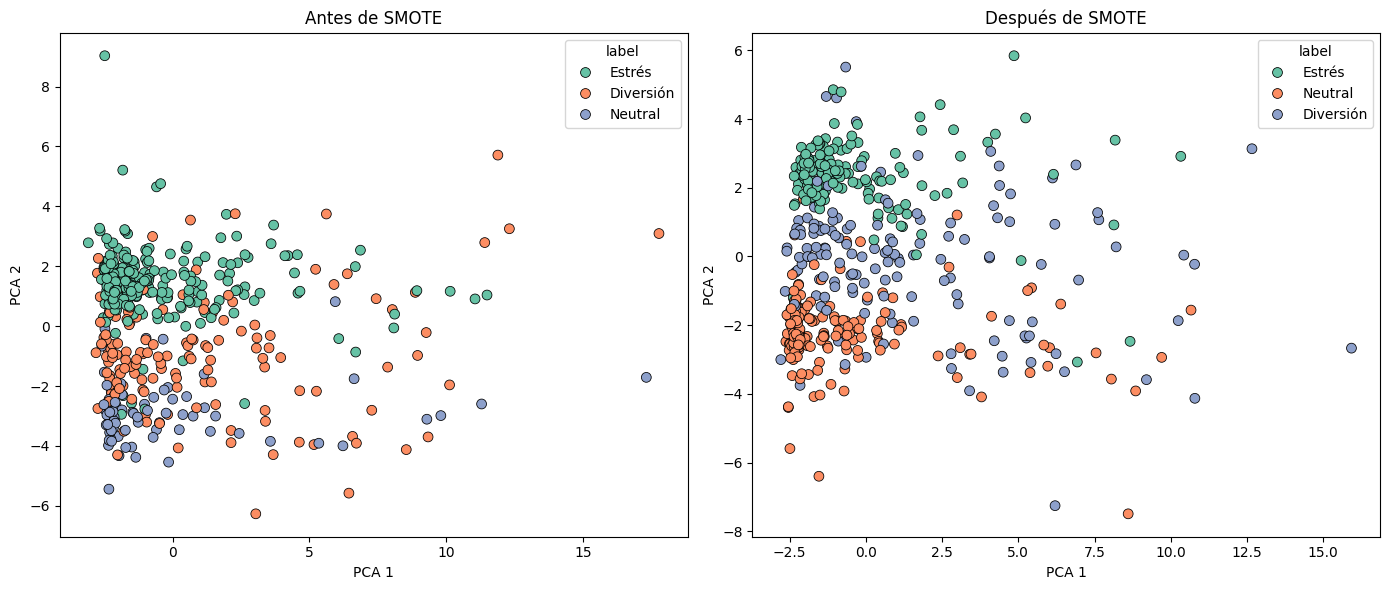

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Mapeo correcto basado en WESAD
label_map = {
    0: 'Neutral',
    1: 'Estrés',
    2: 'Diversión'
}

# PCA por separado
pca_before = PCA(n_components=2, random_state=SEED)
pca_after = PCA(n_components=2, random_state=SEED)

# Reducimos dimensiones
X_pca_before = pca_before.fit_transform(X_train_scaled[:len(y_train)])
X_pca_after = pca_after.fit_transform(X_train_resampled[:len(y_train_resampled)])

# Crear DataFrames
df_before = pd.DataFrame({
    'PCA1': X_pca_before[:, 0],
    'PCA2': X_pca_before[:, 1],
    'label': y_train.values
})

df_after = pd.DataFrame({
    'PCA1': X_pca_after[:, 0],
    'PCA2': X_pca_after[:, 1],
    'label': y_train_resampled
})

# Aplicar mapeo de etiquetas
df_before['label'] = df_before['label'].replace(label_map)
df_after['label'] = df_after['label'].replace(label_map)

# Muestreo para visualizar menos puntos
df_before_sampled = df_before.sample(n=500, random_state=SEED)
df_after_sampled = df_after.sample(n=500, random_state=SEED)

# Graficar
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_before_sampled, x='PCA1', y='PCA2', hue='label', palette='Set2', edgecolor='k', s=50)
plt.title('Antes de SMOTE')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_after_sampled, x='PCA1', y='PCA2', hue='label', palette='Set2', edgecolor='k', s=50)
plt.title('Después de SMOTE')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()



Random Forest
              precision    recall  f1-score   support

   Amusement       0.83      0.93      0.88       120
    Baseline       0.96      0.90      0.93       381
      Stress       0.83      0.87      0.85       215

    accuracy                           0.90       716
   macro avg       0.87      0.90      0.89       716
weighted avg       0.90      0.90      0.90       716


SVM
              precision    recall  f1-score   support

   Amusement       0.80      0.91      0.85       120
    Baseline       0.94      0.90      0.92       381
      Stress       0.82      0.82      0.82       215

    accuracy                           0.88       716
   macro avg       0.85      0.88      0.86       716
weighted avg       0.88      0.88      0.88       716


KNN
              precision    recall  f1-score   support

   Amusement       0.77      0.86      0.81       120
    Baseline       0.92      0.88      0.90       381
      Stress       0.73      0.74      0.74       

c:\Users\Lord\anaconda3\envs\Prueba\lib\site-packages\xgboost\core.py:158: UserWarning: [16:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

   Amusement       0.87      0.92      0.89       120
    Baseline       0.96      0.92      0.94       381
      Stress       0.86      0.90      0.88       215

    accuracy                           0.91       716
   macro avg       0.90      0.91      0.90       716
weighted avg       0.92      0.91      0.92       716



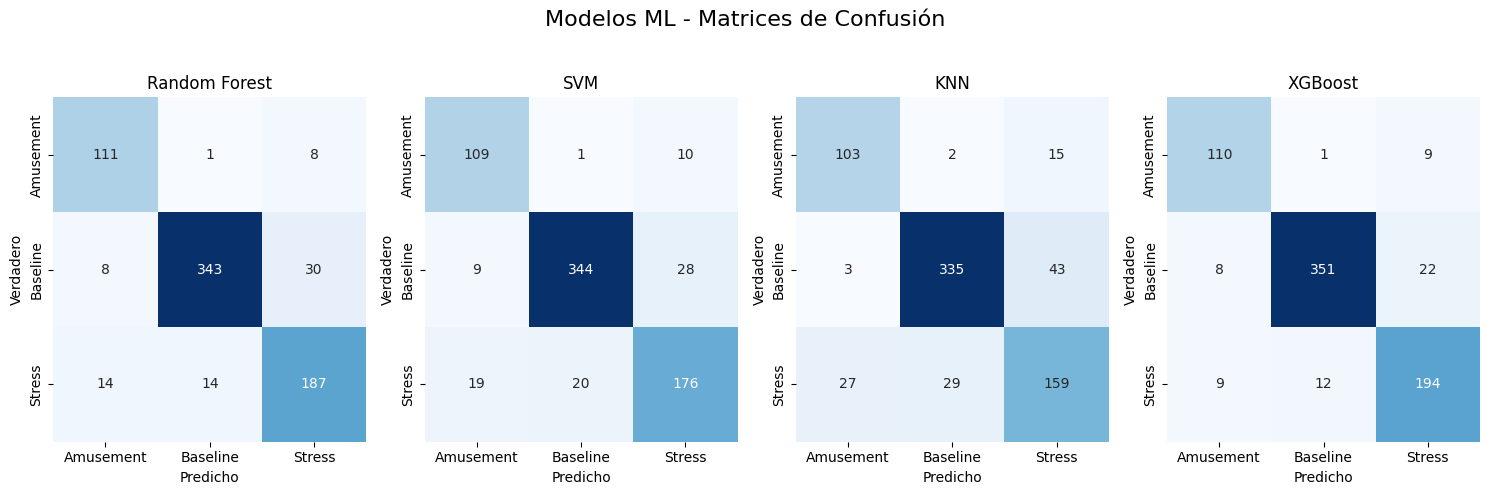

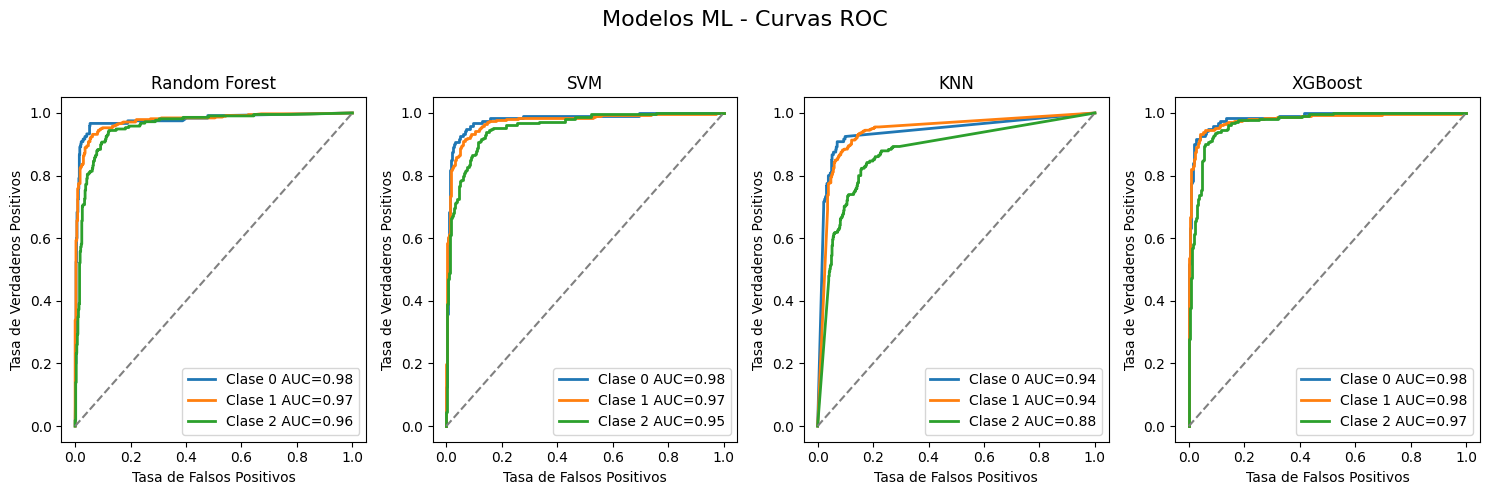

In [23]:
from sklearn.metrics import accuracy_score

# 8. Entrenamiento y evaluación de modelos
models = {
    'Random Forest': RandomForestClassifier(
        max_depth=14,
        max_features='sqrt',
        n_estimators=158,
        min_samples_split=4,
        min_samples_leaf=1,
        random_state=SEED
    ),
    
    'SVM': SVC(
        C=9.715133389830848,
        kernel='rbf',
        gamma='auto',
        random_state=SEED,
        probability=True 
    ),
    
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='minkowski',
        p=2
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=262,
        max_depth=7,
        learning_rate=0.12136242862814803,
        subsample=0.7658003745089468,
        colsample_bytree=0.7802146156268304,
        gamma=0.011644899503096218,
        min_child_weight=1,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=SEED
    )
}


# 6. Entrenamiento y almacenamiento de predicciones
y_true_list = []
y_pred_list = []
y_proba_list = []
model_names = []

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None

    print(classification_report(y_test, y_pred, target_names=['Amusement', 'Baseline', 'Stress']))
    y_true_list.append(y_test)
    y_pred_list.append(y_pred)
    y_proba_list.append(y_proba)
    model_names.append(name)

# 7. Funciones de gráficos
def plot_confusion_matrices(y_true_list, y_pred_list, model_names, scenario):
    fig, axes = plt.subplots(1, len(model_names), figsize=(15, 5))
    fig.suptitle(f"{scenario} - Matrices de Confusión", fontsize=16)
    for i, (y_true, y_pred, name) in enumerate(zip(y_true_list, y_pred_list, model_names)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i],
                    xticklabels=['Amusement', 'Baseline', 'Stress'],
                    yticklabels=['Amusement', 'Baseline', 'Stress'])
        axes[i].set_title(f"{name}")
        axes[i].set_xlabel("Predicho")
        axes[i].set_ylabel("Verdadero")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_roc_curves(y_true_list, y_proba_list, model_names, scenario):
    fig, axes = plt.subplots(1, len(model_names), figsize=(15, 5))
    fig.suptitle(f"{scenario} - Curvas ROC", fontsize=16)
    for i, (y_true, y_proba, name) in enumerate(zip(y_true_list, y_proba_list, model_names)):
        if y_proba is not None:
            y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
            for j in range(3):  # Para cada clase
                fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_proba[:, j])
                roc_auc = auc(fpr, tpr)
                axes[i].plot(fpr, tpr, lw=2, label=f'Clase {j} AUC={roc_auc:.2f}')
            axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')
            axes[i].set_title(name)
            axes[i].set_xlabel("Tasa de Falsos Positivos")
            axes[i].set_ylabel("Tasa de Verdaderos Positivos")
            axes[i].legend(loc="lower right")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 8. Graficar resultados
plot_confusion_matrices(y_true_list, y_pred_list, model_names, "Modelos ML")
plot_roc_curves(y_true_list, y_proba_list, model_names, "Modelos ML")

In [24]:
# import os
# import joblib

# # Crear la carpeta si no existe
# os.makedirs('result', exist_ok=True)

# # Guardar modelo y scaler juntos
# modelo_y_scaler = {
#     'modelo': models['Random Forest'],
#     'scaler': scaler
# }

# ruta_salida = os.path.join('result', 'ModeloFinal.pkl')
# joblib.dump(modelo_y_scaler, ruta_salida)
# print(f"Modelo guardado exitosamente en: {ruta_salida}")